#1. Why NoSQL

Basically NoSQL:
* Maybe you dont need to issue arbitraty qyerues across your entire dataset.
* Maybe you just need to answer a specific question: "What movie should I reccommend?", "What web pages has this customer looked at in the past?".
  * If you need to do this at very large scale, very quickly, across a large dataset, in Real time, NoSQL is for you.

* Basically very scalable horizontal databases.


## HBASE
This is built on top of HDFS, this allows you to have a very fast,scalable transactional system to query data store on an HDFS system.





## NOSQL

Before NoSQL you had to go thorugh extreme measures to make your SQL system scale up. This was horrible. (See image).

Note: A question to ask is, Do I really need SQL? Sometimes you just need simple queries where SQL is overshot. Also you can have the two of them running so... Just choose whatever suits you the best.

So the approximate architecture of NoSQL is:
  * You have something that routs a request (eg. a server that needs a specific site for a customer). (I think here you have a diccionary that directs you to the correct shard)
  * You have multiple shards on your database and each handles a subset of your population.
  * You have backups of all shards.

Basically just use the right tool for your necessities.


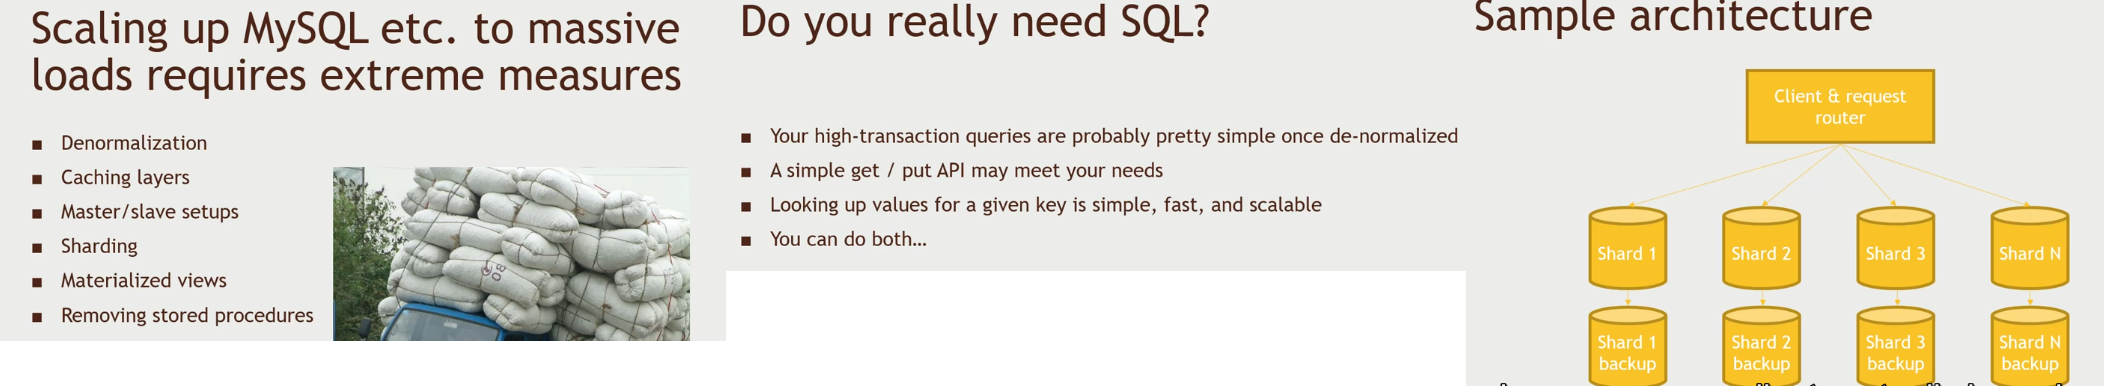

Now, an example of NoSQL
We try to vend the last few pages that a given visitor looked at.
1. We have a data source (like the actual web server)
2. That feeds data in real time to Hadoop (Trough Spark Streaming, Flume, etc) and transforms it into the views you need for the front end.
3. Now it passes to MongoDB (NoSQL solution). 
4. The front end servers ask MongoDB to do something "give the list of the most recent web pages that were viewed for this customer ID".
5. Thorugh the internet and web servers it goes to the User browser.



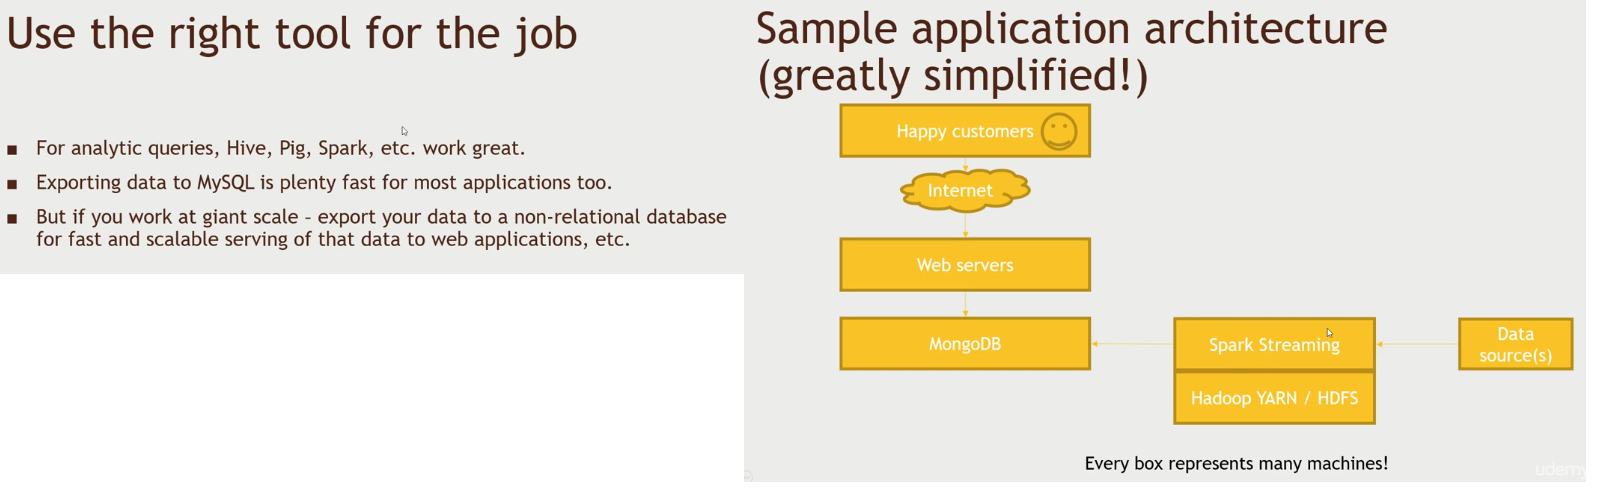

#2. What is HBase.

It is a non-relational scalable database built on HDFS. It does not have a query language but it does have an API that quickly answers the question: "what are the values for this key?" or "store this value for this key".

Note: google "Big Table" paper is what HBase is based on.





## HBase API: CRUD
In HBase you can do what are called CRUD opperations:
* Create: Create a row in a database
* Read: Read back the values of a row
* Update: Update a row in a database.
* Delete: Delete a row in a database.


Under the hood HBase is basically split up into region servers, Regions are ranges of keys, (its like sharding or range partitioning). The magic of HBase is that it can automatically adapt, so as your data grows, it automatically repartition things, so if you add more servers it automatically deals with that (at runtime).

NOTE: HMaster is sort of the mastermind of the HBase cluster that knows where everything is, and that depends on Zookeeper.



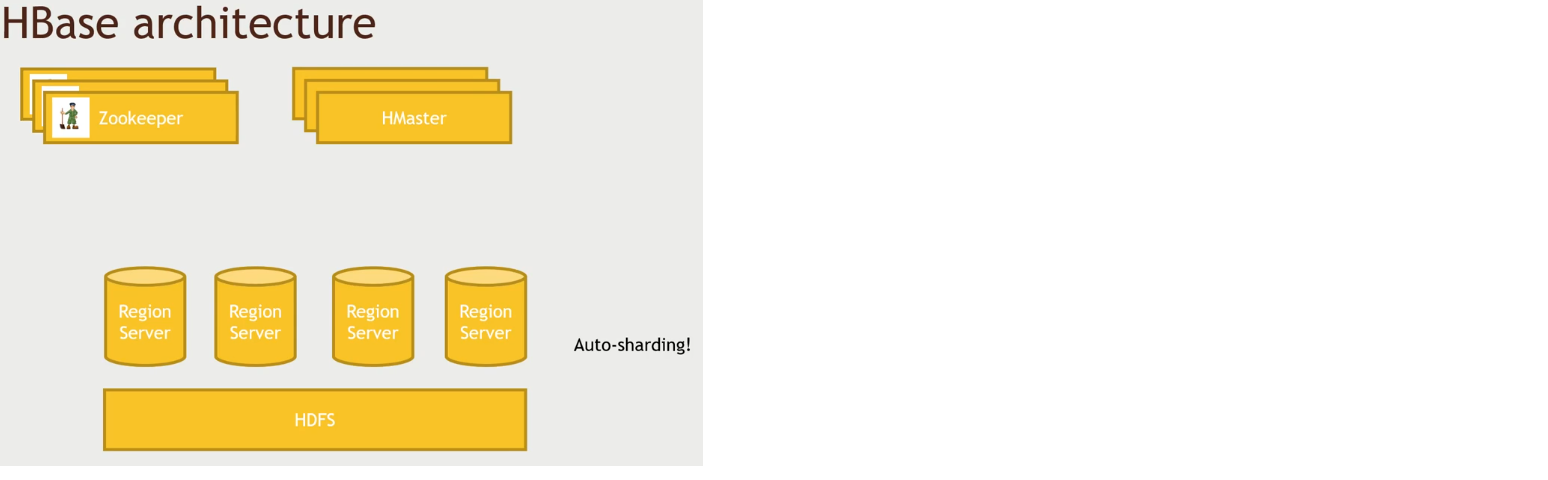

## HBase data model
(Like any database it has rows, where the rows are idenfied by some key value)
* Fast access to any given ROW.
* A ROW is referenced by a unique KEY. Eg, a customer database table might have rows identified by a customer ID, and it might have columns that map to the customer info (name, adress, etc...) 
* Each ROW has some small number of COLUMN FAMILIES: In Hbase you do not define a set of columns, you define column families and a family can contain large numbers of individual columns (This is useful when you have sparse data). (Eg. Every user does not have to have rating data for every movie).
* You can have a very large number of COLUMNS in a COLUMN FAMILY
* You can have a very large number of COLUMNS in a COLUMN FAMILY
* Each CELL can have many VERSIONS with given timestamps: A CELL is given by the intersection of a row and a column.
* Sparse data is A-OK - missing columns in a row consume no storage.

## Example, One row of a web table:

We want to be able to track all the links that connect to a given webpage. (Eg. who links to CNN.com)

NOTE: the key is stored backwards: "com.cnn.www" this is because the keys are looked for lexographically (w is at the end).

There are the Content columns, where (In this case) the last 3 incarnations of the webpage is stored (check image for structure).

Then there is the anchor column family, this is where they store all of the pages on the web that link back to CNN.com. What you actually store whithin the column is the anchor text itself (the link text).

This particular data model allows you to avoid storing the fact that CNN.com is not liked to by many websites (only the ones that link you to CNN matter).

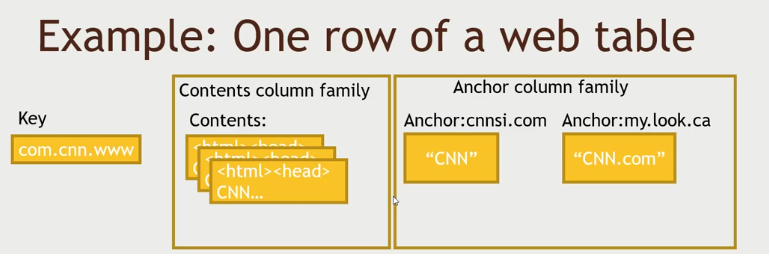

## Some ways to access HBase
* HBase shell
* Java API
  - Wrappers for Python, Scala, etc...
* Spark, Hive, Pig
* REST service: Rest is just a way of getting results through HTTP requests.
* Thrift service: This and AVRO gives MAX performance (With their own cavebeats)
* Avro service

#3. Import movie ratings into HBase

* We want to create a HBase table for movie ratings by user.
* Then show we can quickly query it for individual users
* Good example of sparse data.

The power here of HBase is that it is fundamentally row-oriented. So, for a given user ID, we want to look up very quickly the movies that that user rated.

NOTE: Remember that the actual rating data is provided one line at a time for each individual rating of a user for a given movie. What we will do is write a script that populates the HBase table given that information that constructs the table that looks more like the image. 


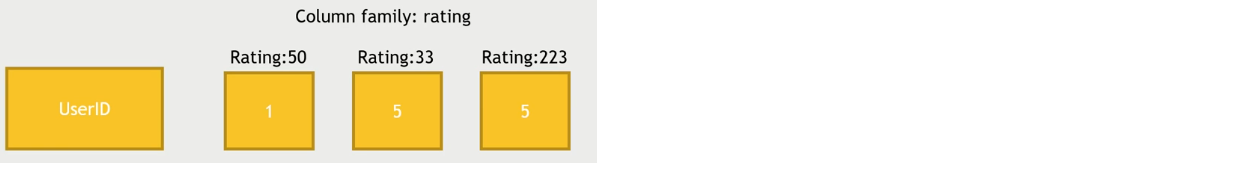

So we build a service that will very quickly give back all the ratings for a given userID. So we want to get back a structure like the image: For a given user ID, give me back all of the ratings for that user ID. So each individual column in the column family for "Rating" will represent a rating for an individual movie.

The scheme here is the row ID has a unique key of "UserID", and each user ID has a "Rating" column family, and this "Rating" column family can consist of ratings of any number of individual movies:
  * Rating:50 says that this user rated the MovieID 50 as 1 star (image).
  

### How will we do it?

We will run a REST service on top of HBase.
* So we have HBase on top of the HDFS file system, 
* and then we run the REST service on top of HBase as just a service that you can query through HTTP requests.
* We write a (python) client that actually queries that service to store and retrieve data through the REST service.

NOTE: Every part of the service runs on a virtual machine, except for the python client (Which will run on the desktop, its like you are running it from a different system)


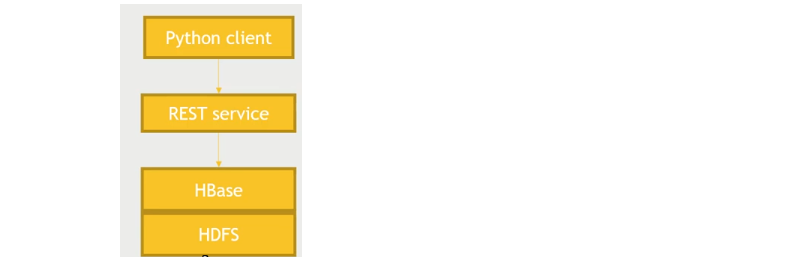

### Building it.

1. Run the sandbox
  * We have to open up a port so the python script can actually talk to the REST service on top of HBase.
    + We go to VBox settings
    + Go to network -> advance tab
    + Go to port Forwarding
    + Open up port 8000 on 127.0.0.1 (This means you can communicate through the virtualbox on port 8000 to my REST service)

2. Go to ambari dashboard (log in as admin)
  * Go to Hbase service (at the side)
  * Go to Service Actions -> start

3. Lunch a REST server on top of HBase so you can communicate it with the outside world.
  * Open PuTTY
  * `su root` (We superuser up to root)
  * `usr/hdp/current/hbase-master/bin/hbase-daemon.sh start rest -p 8000 --infoport 8001`  We open the REST server sitting in top of HBase. the infoport parameter just gives you some info?
  * At this point we have an Hbase instance running on top of our HDFS instance and a REST server sitting on top of that that can vend GET and PUT requests and whatever else to whatever service we have sitting outside of our HBase cluster.

This is literally all you have to do for the backend.

 Now the frontend

 1. Open python environment

In [0]:
#starbase is basically the REST client for HBase with a Python wrapper on top of it.
from starbase import Connection 

# Create a connection agent for our localhosts IP adress 
# and the port we opened, and told REST to operate on.
c = Connection("127.0.0.1", "8000")

# create a table named 'ratings'
ratings = c.table('ratings')

#if the table already exists, drop it and replace with a new one.
if(ratings.exists()): 
  print("Dropping existing ratings table\n")
  ratings.drop()

#whithin the ratings table create a ratings column family on a given table.
ratings.create('rating')

# We open up the dataset (which is in our own system)
print("Parsing the ml-100k ratings data... \n")
ratingFile = open("e:/Downloads/ml-100k/ml-100k/u.data", "r")

# the starbase package has a batch interfase, 
# instead of adding one row at the time, the program batches things up (which is faster)
# So we create a batch object for our ratings table.
batch = ratings.batch()

# We update the batch with new rows, 
# where the row ID is given by the user ID we extract from the u.data file
# and the 'rating' column family (the last line) 
# is going to populate itself with the rating column of the movieID 
# with a given rating value.
# This ends up with a row that has a unique key of the user ID.
# Under the rating column family we construct individual columns for each unique movie ID,
# So the column will be given by "Rating:<movie>"
# And the actual value in each cell is the rating itself.

# Basically we get the data values from each line in u.data.
# Then we update the batch data with a format of Key = userID 
# And the values you retrieve are the movieIDs and their ratings
for line in ratingFile:
  (userID, movieID, rating, timestamp) = line.split()
  batch.update(userID, {'rating': {movieID: rating}})

# Close the ratings file
ratingFile.close()

#We commit the batch trough the service so it actually gets written into HBase
print("Committing ratings data to HBase via REST service\n")
batch.commit(finalize = True)

#Now we can query data back.
print("Get back ratings for some users... \n")
print("Ratings for user ID 1:\n")
print(ratings.fetch("1")) #This gives back all of the movie ratings for userID 1
print("Ratings for user ID 2:\n")
print(ratings.fetch("33"))

# To clean up
ratings.drop()

### Shut everything down:

1. In PuTTY:
  * `/usr/hdp/current/hbase-master/bin/hbase-daemon.sh stop rest` And we shut down our database REST interface

 

# 4. Use HBase with Pig to import data at scale.

Some conditions and notes:

* Must create HBase table ahead of time.

* Your relation must have a unique key as its first column, followed by subsequent columns as you want them sabed in HBase.

* USING clause allows you to STORE into an HBase table

* Can work at scale - HBase is transactional on rows.



## Doing it.

1. Go to ambari and get to your HBase tab, we gonna import the users table from the MovieLens dataset. This database contains information about each individual person that's rating movies in there. (things like their age, occupation, etc..)
2. We have HDP running in virtualbox and the HBase service running on it (from previous tut).

3. Go to files_view in ambari -> user/maria_dev/ml-100k/ -> here we upload u.users simply using the upload plugin in ambari.

4. Create an HBase table to receive the information.
  * Go to PuTTY (log in as root) (or admin and give root privileges?)
  * `hbase shell`, here we could type `list` to get a list of all the existing tables in the hbase instance
  *  `create 'users', 'userinfo'` this says: create a new table called 'users' that consists of the following column families (the column family we give it is userinfo).
  * `exit`

5. Download a PigScript to do what we need to do
  * ´wget http://media.sundog-soft.com/hadoop/hbase.pig´
```
users = LOAD '/user/maria_dev/ml-100k/u.user' 
USING PigStorage('|') 
AS (userID:int, age:int, gender:chararray, occupation:chararray, zip:int);
```
```
STORE users INTO 'hbase://users' 
USING org.apache.pig.backend.hadoop.hbase.HBaseStorage (
'userinfo:age,userinfo:gender,userinfo:occupation,userinfo:zip');
```
  * This script:
    + We create a relation named "ratings" created by loading from HDFS the file u.user
    + Then we tell it to use the | as a delimeter (thats what pigstorage does)
    + and we store it in that format. NOTE: The first column has to be the key (the userID), the it is followed by everything we want to put into the "userinfo" column family.
    + ´USING´ X class name, which tells it to use this piece of code to transmit the data into HBase.
    + And then we give it the actual mapping to HBase columns. NOTE: the key is implicit,so the first column will allways be extracted and used as the row key value, but then we take the second value (the age) and map it to the userinfo:age column, followed by every column we have (userinfo:gender, userinfo:occupation, etc...)

  * To run it you type ` pig hbase.pig` 

NOTE: probably you can use Spark scripts as well here.


Now in PuTTY to see if it is there:
* `hbase shell` enter HBase
* `scan 'users'` here we can take a peak of the database.

NOTE: HBase inserts a timestamp of when the data was added or updated, 
etc.

* `disable 'users'` we have to do this before dropping the table.
* `drop 'users'` To delete the table and clean
* `exit`
* In ambari go to HBase tab -> services -> stop


#5. Cassandra overview.

Cassandra is a distributed database system and it has no single point of failure, it has no master note, it is engineered for availability avobe all else. 



## Cassandra - NoSQL with a twist.
* Unlike HBase, there is no master node at all, every node runs exactly the same software and performs the same functions.
* Data model is similar to BigTable/HBase
* It's non-relational, but has limited CQL query language as its interface. (No JOINS, etc..., just vending data).


## Cassandra's Design choices.

Cassandra has The "CAP" Theorem, Consisntecy, availability, and partition tolerance.
* The CAP theorem says you can only have 2 out of 3.
  - And partition-tolerance is a requirement with "big-data" so you really only choose between consistency and availability

* Cassandra favors availability over consistency
  - it is "eventually consistent"
  - But you can specify your consistency requirements as part of your requests. So really it's "tunable consistency", you can tune cassandra to be more/less consistent if needed

The pilars:
  + Consistency: When I write something to my database, I'm going to get the answer back right away no matter what. Cassandra offers "eventual consistency", meaning that if I write a value, maybe it's OK if that new value doesn't actually come back for a second or two. (Eg, in social media, "¿Is it the end of the world if the Post I make in social media is not seen immediately?"
  + Availability: Your database must be allways up and running
  + Partition tolerance: Your database can be easily spread up.



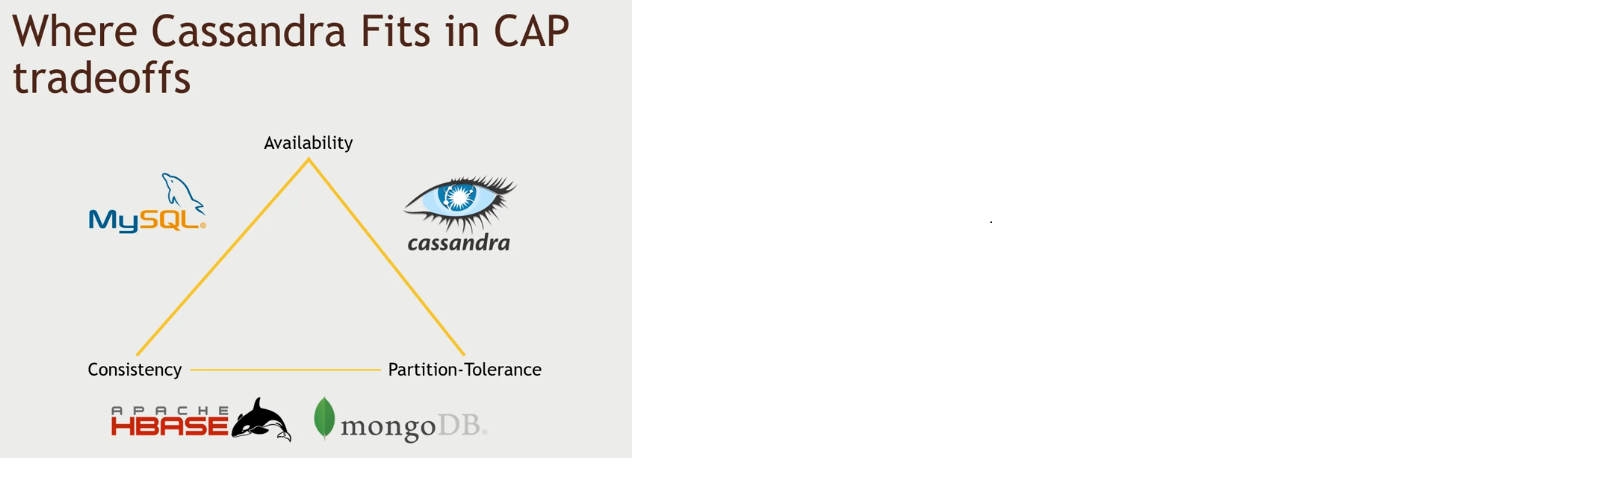

A few comments on the triangle:

* HBase: You only have one master-node, if your master goes down, or zookeeper goes down, your whole database dies.

* Other things like Oracle or MySQL where there is more challenge to distributing data across a cluster (partition)


### Cassandra architecture

Cassandra has a "ring" architecture, it does not habe any masternodes to keep track of its status. Instead it uses a "gossip protocol" so that every node in your cluster is communicating with each other to keep track of who is resposible for what bits of data (where the data is replicated, etc...). The client can talk to any node to find out anything.
The nodes manage themselves.

To enforce high consistency, you can say: "I want to get back the value for this key in this database, but im only gonna accept that value, if, say, 2 out of the 3 nodes agree on the same value". Basically: "im waiting for to make sure everything is consistent"

**You can integrate cassandra with a Hadoop cluster**, you can actually set up separate racks and data centers of Cassandra nodes and Cassandra can be aware of those and actually manage the replication between them.

A common pattern is having a Cassandra ring that is responsible for handling online queries (Transactional queries) and that can replicate to another Cassandra cluster that propagates that same data across, and you can use Zephyr analytics. So you can use that copy of your Cassandra to integrate with your Hadoop cluster and operate Hive or Spark queries on it to analyze the data in something like a batch-oriented system, analytics system. This way you can run big analytics on your Cassandra data without impacting the performance of your transactional system that might be serving a web front-end.




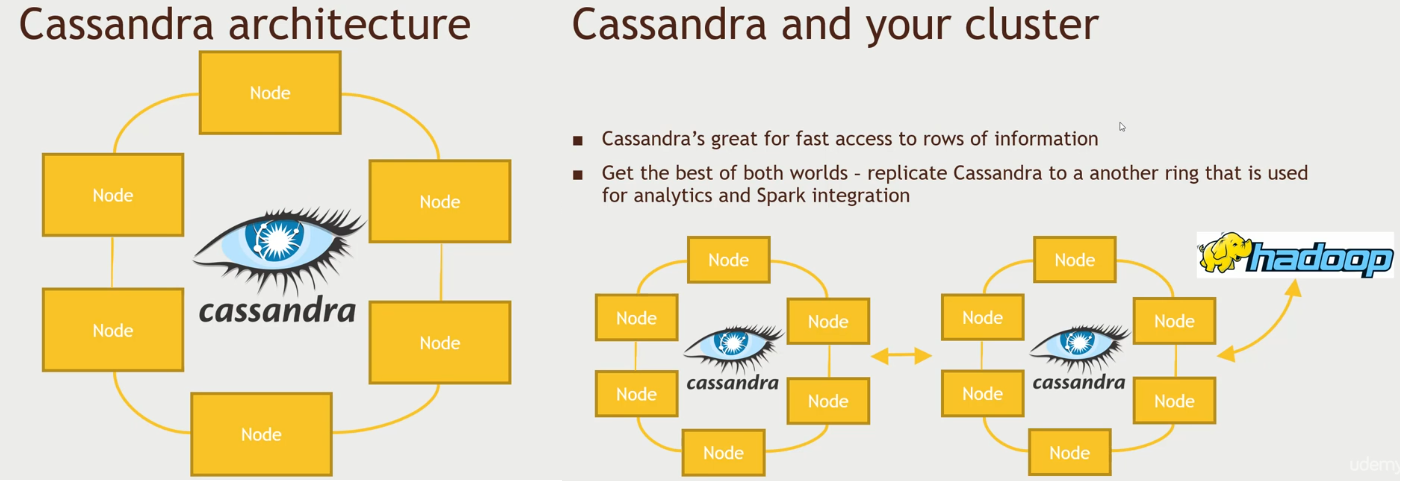

###Cassandra CQL

* Cassandra's API is CQL, which makes it easy to look like existing database drivers to applications.

* CQL is like SQL, but with some big limitations!
  - No Joins
    + Your data must be de-normalized
    + So, it's still non-relational
  - All queries must be on some primary key
    + Secondary indices are supported (but primary keys just give better performance)

* CQLSH can be used on the command line to create tables, etc...

* All tables must be in a keyspace - keyspaces are like databases. (In MySQL there are databases that consist of tables, while in Cassandra there are Keyspaces that consist of tables...)


### Cassandra and spark

* DataStax offers a Spark-Cassandra connector
* Allows you to read and write Cassandra tables as DataFrames.
* Is smart about passing queries on those DataFrames down to the appropiate level. You can just write code as if it were a dataframe and just attach that dataframe to your cassandra cluster.
* Use Cases:
  - Use spark for analytics on data stored in Cassandra.
  - Use spark to transform data and store it into Cassandra for transactional use.

#6. Installing cassandra.

NOTE: installing cassandra is kindof annoying... And it is likely to change. Look for an updated tutorial when you want to install it for real.

In this version, at this time it is installed like:

1. open PuTTY
2. `su root` to login as root.
3. NOTE: HDP runs python 2.6, and cassandra requires 2.7
4. This is literally kindof useless info, since this changes with each version at each time...

CONCLUSION: I will just "skim" trough this video...

### Once cassandra is installed

1. `service cassandra start` and cassandra starts up. I think you have to install it on every node you want cassandra to run.
2. `cqlsh` To get into the Cassandra api language

We will create a table for the movieLens users dataset.

1. `CREATE KEYSPACE movielens WITH replication = {'class': 'SimpleStrategy','replication_factor':'1'} AND durable_writes = true;` Create a keyspace with the replication properties that we want and durable_writes enabled (We usually want to have this parameters), in real-World applications the replication_factor and replication_strategy (There are different ones, check documentation)

2. `USE movielens;` to use the movielens keyspace, (in PuTTY it shows 'cqlsh:movielens>')
3. `CREATE TABLE users (user_id int, age int, gender text, occupation text, zip text, PRIMARY KEY (user_id));` create a users table containing the specified columns and the user_id as PRIMARY KEY.
4. `DESCRIBE TABLE users` to make sure the table is there and to see details.
5. `SELECT * FROM users;` We select everything (right now the table is empty) 

#7. Write Spark Output into Cassandra



We get into PuTTY (Where we left off, type `exit` to get into PuTTY itself)

1. `wget http://media.sundog-soft.com/hadoop/CassandraSpark.py `get script to integrate with spark (see next code block)

2. `export SPARK_MAJOR_VERSION = 2`  We need to make sure we are using spark 2.0 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions

def parseInput(line): #Parse the input file,
    fields = line.split('|') #The separator of the data.
    return Row(user_id = int(fields[0]), age = int(fields[1]), gender = fields[2], occupation = fields[3], zip = fields[4])

if __name__ == "__main__":
    # Create a SparkSession
    # We name the application 'CassandraIntegration'
    # We pass a config parameter that tells the app "where am I running cassadra from"
    # In this case we are running it on localhost (127.0.0.1)
    # Get or create, creates it or takes it if it exists
    spark = SparkSession.builder.appName("CassandraIntegration").config("spark.cassandra.connection.host", "127.0.0.1").getOrCreate() 

    # Get the raw data
    # Basically parse through the u.user file
    # We assume that it is already installed in hdfs
    # You can log in to ambari to -> files view, and double-check the file exists.
    # literally just take all the lines in the file
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.user")
    # Convert it to a RDD of Row objects with (userID, age, gender, occupation, zip)
    users = lines.map(parseInput)
    # Convert that to a DataFrame
    usersDataset = spark.createDataFrame(users) 

    # Write it into Cassandra
    # the format argument means that there is where it will find that package??
    usersDataset.write\
        .format("org.apache.spark.sql.cassandra")\
        .mode('append')\ #We append to the table we have in Cassandra
        .options(table="users", keyspace="movielens")\ #We indicate the table and keyspace
        .save() # save the changes.

    # Read it back from Cassandra into a new Dataframe
    # The same format argument and same talbe and keyspace
    # We just load at the end
    # We now have a readUsers dataframe with the data.
    readUsers = spark.read\
    .format("org.apache.spark.sql.cassandra")\
    .options(table="users", keyspace="movielens")\
    .load()

    #Create a view so we can work with it in python/spark
    readUsers.createOrReplaceTempView("users")
    
    # Simple spark/sql query 
    sqlDF = spark.sql("SELECT * FROM users WHERE age < 20")
    sqlDF.show()

    # Stop the session
    spark.stop()

Now we run this:

Note: one trick: you can't just pass in "org.apache.datastax.sql.cassandra" and expect it to work. IT HAS TO FIND THE PACKET. We need to pass it as a parameter to our script when we run it.

In PuTTY:
1. `spark-submit --packages datastax:spark-cassandra-connector:2.0.0-M2-s_2.11 CassandraSpark.py` it's a wrapper script for spark that submits the script to our cluster. THIS SPECIFIC PACKAGE NAME MIGHT CHANGE IN THE FUTURE, for now this is saying that i want the version of the connector that is compatible with Spark 2.0 and Scala version 2.11.

To check if the data was efectively written in Cassandra:

1. `cqlsh --cqlversion="3.4.0"` open cqlsh
2. `USE movielens;` to select the keypace
3. `SELECT * FROM users LIMIT 10;` and we select the data from the database. (And we do have data!)
4. `exit`
5. `service cassandra stop` To shutdown Cassandra.
 



# 8. MongoDB overview
MongoDB is preferred in coorporate environment because it is distributed and supported by an actual company.

"You can stick anything you want into mongoDB, any JSON blob of data" The data does not have to be structured, you do not need to have the same schema, you can basically put whatever you want in there.


MongoDB automatically gives your document or piece of data a unique ID. This is because there is nothing in MongoDB that actually says that you have to have a unique field at all.

### No Real schema is enforced in MongoDB
* You can have different fields in every document if you want to. - Not really a good idea if you want to have fast lookups.
* No single "key" as in other databases.
  - But you can create indices on any fields you want, or even combination of fields. - Very flexible on how to index the data.
  - If you want to "shard, then you must do so on some index.
* Results in a lot of flexibility.
  - But with great power comes great responsibility. - "Just because you can add anything to the database, does not mean you should..."



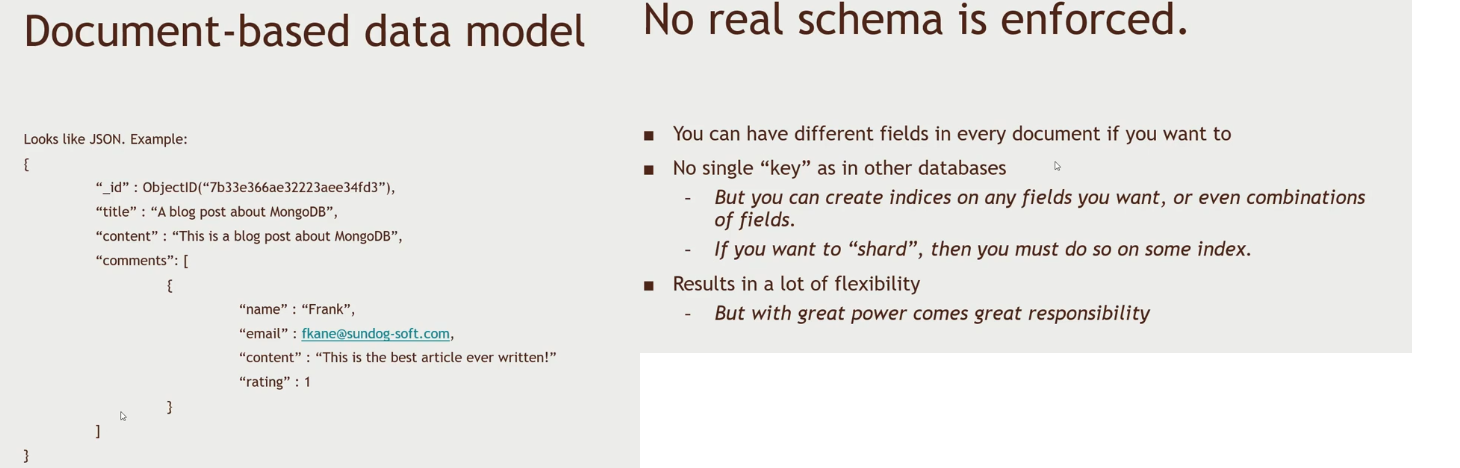

### MongoDB terminology:
- Databases
- Collections: (Tables)
  * Contains a collection of documents
    + Instead of tables with rows you have collections that contain documents.
    + collections can contain anything
    + The main restriction is that you cannot move data between collections across different databases.
- Documents (Rows)


### Replication Sets (mongoDB architecture)

* MongoDB has a single-master architecture.

* Mantains backup copies of your database instance.
  - Secondaries can elect a new primary whithin seconds if your primary goes down.
  - But make sure your operation log is long enough to give you time to recover the primary when it comes back..

What this basically means is that MongoDB has Replica-Sets, you can have this secondary databases that mantain copies over time from your primary database, as writes happen from your primary database, those writes get replicated through an operation log to any secondary nodes you might have attached to it.

You can have secondaries in different server locations, etc... Secondaries are usually arbitrary selected

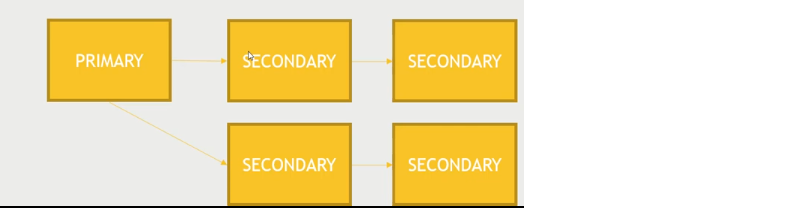

### Replica Set Quirks
There are a lot ofquirks in mongoDB, and it gets some critisism for that.

* A mayority of the servers in your set must agree on the primary.
  - Even number of servers (like 2) don't work well with mongoDB (because if one agrees and not the other... there are issues)

* Don't want to spend money on another server? (A third server?) You can set up an 'arbiter' node
  - You can only set up one.

* Apps must know about enough servers in the replica set to be able to reach one to learn who's primary.   
  + That means that if you will be modifing your servers, you need to push that info all the way up to your application, and that can be a pain...

* Replicas only adress durability, not  your ability to scale
  - Well, unless you can take advantage of reading from secondaries(Which genrally is not recommended)
  - And your DB will still go into read-only mode for a bit while a new primary is elected.

* Delayed secondaries can be set up as insurance against people doing dumb things.
  + Eg. you set up a 1h delay between primary and secondary replication, and you do something really dumb, you could shut down and restore from the delayed secondary state.
  

### Sharding

To actually scale up data across more than one server with MongoDB, you need sharding.

Sharding works by having multiple replica sets, where each replica set is responsible for some range of values on some index values in my database.

To get sharding to wrok you have to set up an index on some unique value on your collection and that index is used to actually balance the load of information on multiple replica sets. And then on each application server, wherever you are using to talk to mongoDB, you will run across MongOs, which talks to three configuration servers that know about how things are partitioned and then used that to figure out which replica set do i talk to to get the information that i want.

Some grounding:
  * You can have may application servers, (A web service or web app) Where each process is running an instance of mongOs, this instances of mongOs has a comunication with 3 configuration servers running somewhere (This can run on top of any server you might have), from there it figures out which replica set to talk to, to actually read or write the information for a given user_id or any data you are indexing on, and that replica set in turn takes care of durability and back itself up into a bunch of secondary nodes.

MongOs is running something called a "balancer" in the background so over time if it finds it does not have an even distribution of values you are partitioning on, it can rebalance this across replica sets.

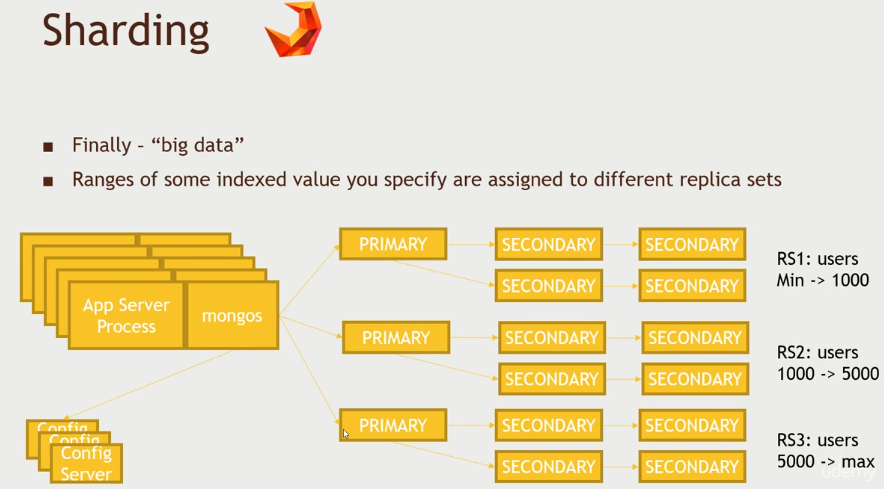

### Sharding quirks

* Auto-sharding (The balancer) sometimes doesn't work.
  - Split storms, mongos processes restarted too often. (Basically it takes mongo time to check how everything is balanced and distributed, if you restart your cluster, this process gets restarted as well, making it useless.)

* You must have 3 config servers.
  - If any of your config servers go down, your DB is down.
  - This is on top of the single-master design of replica sets.

* MongoDB's loose document model can be at odds with effective sharding.

### Neat things about MongoDB
* It's not just a NoSQL database - very flexible document model.
* Shell is a full JavaScript interpreter.
* Support many indices
  - But only one can be used for sharding
  - More then 2-3 are still discouraged.
  - Full-text indices for text searches
  - Spatial indices.

* Built-in aggregation capabilities, MapReduce, GridFS.
  - For some applications you might not need Hadoop at all.
  - MongoDB still integrates with Hadoop, Spark and most languages.

* A SQL connector is available.
  - MongoDB still is not designed for joins and noramalized data.

# 9. Install MongoDB and integrate Spark with MongoDB

1. Open up PuTTY and your HDP Sandbox.
  * NOTE: Ambari has a mongoDB ambari connector, we go to github to get it..
2. `su root` to get all permissions.
3.  `cd \var\lib\ambari-server\resources\stacks` then -> `ls` -> `cd HDP` Here we see the version of the hadoop sandbox you installed. -> `cd 2.5` Basically go into the version you have -> `cd services` -> `pwd` this shows us where we are (The folder path). 
4. `git clone https://github.com/nikunjness/mongo-ambari.git` and take the connector from github.
5. `sudo service ambari restart` restart the ambari server so it sees this new data and picks it up.

Now we log in into ambari to finish the setup

6. In ambari dashboard, to the side there is an "actions" button -> press add-Service. 
7. MongoDB should be in the service list, click the square and check it.
8. click the next buttons at default and save. (Proceed anyway) -> complete

**NOTE: MongoDB NEEDS to allways be properly shutdown, or you might get into a situation where you need to delete your virtual image to reinstall it.**


## Copy our "users" database from the movielens dataset into MongoDB and read it back.

1. Make sure you already have your dataset in Hadoop -> in ambari -> files view -> usr/maria_dev/ml-100k, u.users should be there

We have to go back to PuTTY to finish installing what we need for python.

1. in PuTTY -> `pip install pymongo`
2. Now we check our script (See code cell)

Now we run the script.

1. in PuTTY (if you are in root use `exit` to exit out of root and go to your home directory (using `cd ~` should work)
2. get a copy of the script on the environment: `wget http://media.sundog-soft.com/hadoop/MongoSpark.py` (You can import it from internet or from your local disk)
3. `export SPARK_MAJOR_VERSION = 2` To tell it to run on SPARK2
4. `spark-submit --packages org.mongodb.spark:mongo-spark-connector_2.11:2.0.0 MongoSpark.py` This tells it where to actually find the code for the MongoDB connector for spark. NOTE: if you are running on another version of the Hortonwork sandbox, this values might be different. The syntax means: We want the connector for scala 2.11 and for Spark 2.0.0, if needed this numbers might have to change. Then we just add the script.

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions

def parseInput(line):
  fields = line.split("|")
  return Row(user_id = int(fields[0]), age = int(fields[1]), gender = fields[2], occupation = fields[3], zip = fields[4]  )

if __name__ == "__main__":
  #Create a SparkSession
  spark = SparkSession.builder.appName("MongoDBIntegration").getOrCreate()

  #Get the raw data
  lines = spark.sparkContext.textFile("hdfs///user/maria_dev/ml-100k/u.user")
  #Convert it to a RDD of row objects with (UserId, age, gender, occupation,zip)
  users = lines.map(parseInput)
  # Convert that to a DataFrame
  usersDataset = spark.createDataFrame(users)

  # NOTE: EVERYTHING AVOBE THIS IS BASICALLY THE SAME FOR ALL DATABASES
  # WE ARE JUST TAKING AND "PROCESSING" THE DATA FROM HDFS

  # Write it to mongoDB
  # Here we write it to mongoDB
  # It is very similar to Cassandra or other DataBases we have with some specific changes
  usersDataset.write\
    .format("com.mongodb.spark.sql.DefaultSource")\ #Tie the database to mongoDB
    .option("uri","mongodb://127.0.0.1/movielens.users")\ #we talk to mongoDB on the local server
    # we want to talk to the movielens database and the users collection
    .mode("append")\ #if it already exists append the data into that collection if it already exists
    # If it does not exists create one automatically.
    .save() #save it.

  # Read it back from MongoDB into a new DataFrame
  readUsers = spark.read\
  .format("com.mongodb.spark.sql.DefaultSource")\
  .option("uri","mongodb://127.0.0.1/movielens.users")\
  .load() #Same parameters from before, but we load
  # Note: You are not actually loading the entire contents of the collection in memory

  #Create a temporary view in spark to work with it.
  readUsers.createOrReplaceTempView("users")

  #Get some query
  sqlDF = spark.sql("SELECT * FROM users WHERE age < 20")
  sqlDF.show #Show your result

  #Stop the session
  spark.stop()

  # Note: The MongoDB connector is smart enough to push the logic down to MongoDB itself
  # So you are NOT loading the data locally into spark and running a query on it
  # What it's actually doing is figuring out how to translate the SQL query 
  # into a MongoDB query and actually execute that on MongoDB and
  # return the results from MongoDB

# 10. Using the MongoDB Shell

1. In PuTTY -> maria_dev -> `mongo` to enter the MongoDB shell, this gives us a shell prompt from which we can execute any arbitrary javascript.

2. `use movielens` This is written inside the mongo shell. This allows us to get into the movielens databse that we wrote last section and from there we can do queries.

3. `db.users.find( {user_id:100} )` This brings back any documents that match the expression where the user_id = 100.

NOTE: we never set up an index, so when it searched for user_id:100 it did so very inefficiently. It had to do a full tablescan.

4. `db.users.explain().find({user_id:100})` And this explains what MongoDB did under the hood to find the expression. In this case all it is doing is a scan looking for user_id 100 going forward. (Really inefficient)

**Lets make an index to fix this:**

1. `db.users.createIndex({user_id: 1})` This means that you want to create an index on the user_id field, and the "1" means in ascending order.



### Playing aroung with MongoDB

Aggregating all the users by occupation and figure the average age for each occupation.

1. In the mongo shell inside PuTTY `db.users.aggregate( [{$group: { _id: { occupation: "$occupation"}, avgAge:{ $avg: "$age"  } }  } ])` the $group is a command mongoDB recognizes. The _id indicates the ID of the field, basically that we want to group all the documents by. We are saying we want to group on the "occupation" field, and we are going to name the resulting field that we get back "occupation". Also we average the age field for each document for each occupation.

Some more queries:

1. `db.users.count()` To count the the number of users in the database
2. `db.getCollectionInfos()` Look at the actual collections that are in our database. This returns our "users" collection that we created 

Now we drop our table to clean up.

1. `db.users.drop()`
2. `exit` to get out of Mongo shell

**To close mongoDB properly**

1. Go to Ambari -> Services tab (in top navbar) -> mongoDB
2. Service Actions -> Stop.
3. We can also shut down our virtual image as well. (Not necessary?)


# 11. Choosing a database technology.

Although there is no real formula to follow to choose a database there are things to consider.

* We need to consider the **Integration considerations**, what do we need to integrate togheter?
  + Different technolgies have different connectors for other different technologies.
    - For example, if you have a big analytics job currently running in Apache Spark, then you probably want to limit yourself to external databases that can connect easily to Apache Spark.
    - Maybe you have a front-end system that depends on having a SQL interface to a back-end database, and you're thinking about moving from a monolithic relational database to a distributed non-relational database. In that case it might make life a lot easier if the Non-relational database we are moving to offers some sort of SQL-like interface that could be easily migrated to from your front-end application.
  + Think about what needs to connect and talk togheter and see if this is possible.
    - Check if there are any off-the-shelf/well-mantained technologies that make this easier.

* **Scaling requirements**, How much will our data scale and grow over time?
  + For example here you look at mongoDB, Cassandra or HBase where you can distribute the storage of your data across an entire cluster and scale horizontally instead vertically.

* **Transaction rates** How many requests will you get per second?, if you are talking about thousands or more a single database will not cut it. You need something distributed to spread the load of those transactions evenly. You usually need distributed NoSQL databases
  * Typically these situations mean a big website with lots of servers serving lots of people at the same time.

* **Support considerations** 
  + Do we actually have the expertice to spin off this technology and actually configure it properly?, Somethimes this is harder than it seems. 
    - Can I get constant professional support?
    - Can I ousource the support?
    - Usually MongoDB is a good choice because you can pay for support. There are also companies that offer paid support for the larger Apache proyects.

* **Budget, cost of service**
  + Note: Apart from the support, all of this technologies are Open-source, so this might not be a big concern.
  + You usually just think about the cost of the servers themselves here.
    - Usually you can rent the time you need in the servers with Amazon, Google, Microsoft, etc...

* **Think about the CAP Theorem**
  + See the Triangle.
  + Do you need Consistency or Availability?
    - How important is it to be allways up?
    - How important is speed and eventual consistency?
  + Technology has made this desition not that important, usually all techs have decent degrees of all.

* **Keep it simple** 
  + Check the requirements of your proyect and keep it simple, 
    - If you don't need to deal with massive scale, don't use NoSQL.
  + Do not deplay new systems where you might not have much support or expertice if it is not neccesary.
  + Simple architectures and simple technologies are just easier to work with.







### An example

You're building an interal phone directory app. Its just a little internet page on your organization where you can look up phone numbers and email addresses of workers.
  - Scale: limited
    + No need for a "big data" database
  - Consistency: Eventual is fine
    + If someone changes their mail or phone extention, it is fine if it does now show until a bit later.
    + Availability requirements: Not critical
      - Does it really matter if it goes down for a few minutes? An hour?
      - You might get some annoyed executives.
    + Simplicity: MySQL is probably already installed on your web server...
      - MySQL comes default with many servers. And it's common and simple 

*Basically use MySQL* (A SQL Database).
  - You don't need partition tolerance.
  - It is already installed
  - People already understand it

### Another example

You are setting up a system that mines my web-server logs and tried to look for intersting analytical patterns. (Imagine google analytics for an internal website), You want to answer things like: What's the most popular time of day in my web site What's the average session length?

  * Scaliability: Is this server so big that i need a NoSQL (Non-Relational) database (Do i need partitions)?.
    + If all I am doing is analytics, that's what Hadoop/Spark are for, you can import this data into your cluster (HDFS) and analyze it offline.
 * Transaction rates: Since we are analyzing we don't really need to really quickly get the answer to a specific query over and over many times per second.
  - Note: This high-rate problem is meant for NoSQL, if you don't have that problem, you don't need to use NoSQL.

We can solve this problem just by importing the log data into HDFS - It does not involve external databases at all.
Once the data is on the HDFS cluster, we can write a SPARK job that mines the data, assigns the appropiate structure to it and even run Machine learning algorithms on it using Spark MLLib. 

*In this case you don't even set up an external database at all*... UNLESS we need to vend this data to a very large audience externally.

### Another example
We are importing logs or some customer behavior data, user rating or something like that.

* requirements:
  - You might have a big Spark job that produces movie recommendations for end user nightly

  - Something needs to vend this data to your web applications.

  - You work for some huge company with massive scale

  - Downtime is not tolerated.

  - Must be fast: You have to make sure it does not hold up the rendering of your front-end.

  - Eventual consistency OK - it's just reads. (It's fine if you get the old recommendations for a bit of time if you just computed the new ones)

So. We need NoSQL since it's so large. We care about availiability are willing to give up consistency.

*Cassandra is a good choice*




### Another example but it's an exercise
* Requirements
  - You are building a massive stock trading system
  - Consistency is more important than anything (You have to make sure you get your data right away no matter what)
    + If someone makes a stock trade, you have to make sure that subsequent requests reflect that data instantly.
  - "Big data" is present
    + We need partition tolerance and high transaction rates.
  - It's really important - so having access to professional support might be a good idea
    + Security is tantamount, you have to make sure there are resources to have all the support you need.
  - We have basically unlimited budget.

So:
  + We need NoSQL to scale.
  + Using CAP theory for NoSQL:
    - MongoDB and HBase are consistent. (And partitionable)
  + We need professional support.
    - mongoDB has it.
  
    

# 12. Exercise, choose a database for a given problem.

(Same problem as the last section, a stock trading system)

Here I chose MongoDB by myself. Now using the video.

1. Look at the CAP triangle
  - Choose the options with consistency and Partition-Tolerance.
  - NOTE: Here he says that, even if it might not be availiable sometimes (like if the website goes down a bit), it's fine, because the alternative is to loose your records of the database or get something corrupted or mixed up, and that is really bad in this environment.
  - Here we lean towards HBase or MongoDB.

2. To choose between HBase and MongoDB
  - You go to strong external support
    + MongoDB.
  - Note: There are companies that support HBase too and other projects, for something this big, you should research them and ask them if they have done some similar proyects.
  - Note2: Since HBase is easier to integrate you could even go for it if that is really important..

NOTE: Remember that the CAP theorem is becoming outdated because of technologies advances.
  * Here you could tune up cassandra for your needs.
  * You could even use MySQL if you have experts that can tune the front-end to know which MySQL database to talk to given a range of transaction characteristics. 

